# Evaluation Plots

Vision: 

```
from ocean_emulators.plotting import eval_plots

training_url = ...
prediction_url = ...

eval_plots(training_url, prediction_url)
```

Where

```
def eval_plots(...):
    # Run tests on prediction data
    # Plot all relevant panels in a neat and organized way
```


In [1]:
# ! pip install -e /home/jovyan/PROJECTS/ocean_emulators

In [2]:
import xarray as xr

In [3]:
from ocean_emulators.postprocessing import post_processor, prediction_data_test

In [4]:
ds_input = xr.open_dataset("gs://leap-persistent/sd5313/OM4_Horizontal_Regrid_Old.zarr", engine='zarr', chunks={})
ds_prediction_raw = xr.open_dataset("gs://leap-persistent/sd5313/convnextpredepoch50.zarr", engine='zarr', chunks={})

# our groundtruth is always just a time slice of the training (training is a bad name
ds_groundtruth = ds_input.isel(time=slice(4141, 4741))

# quick fix: 
ds_prediction_raw = ds_prediction_raw.assign_coords(time=ds_groundtruth.time)
# ds_prediction_raw = ds_prediction_raw.swap_dims({'x':'y'}) # why does this not work?
ds_prediction_raw = ds_prediction_raw.rename({'x':'x_i', 'y':'y_i'}).rename({'x_i':'y', 'y_i':'x'})
ds_prediction = post_processor(ds_prediction_raw) #FIXME: This should be done before uploading the prediction output.
# quick fix (coords to lev)
ds_prediction = ds_prediction.assign_coords(lev=range(len(ds_prediction.lev)), x=ds_input.x, y=ds_input.y)

# Run the test to make sure the output is formatted correctly
prediction_data_test(ds_prediction, ds_input)

In [8]:
import numpy as np
ds_raw = xr.DataArray(np.random.random([3,180, 360, 77]), dims=['time', 'y','x', 'var'])

In [7]:
# quickly calculate area (TODO: This should be a coordinate on the ds_training)
import numpy as np

area_weights = np.cos(np.deg2rad(ds_input.y))
area_weights

ds_prediction = ds_prediction.assign_coords(areacello=area_weights)
ds_input = ds_input.assign_coords(areacello=area_weights)
ds_groundtruth = ds_groundtruth.assign_coords(areacello=area_weights)

## TODO:
- add metrics (dz, area)
- Add coordinate values (from source dataset)
- Chunk better
- Add metadata

In [8]:
# for faster dev take only a smaller time range
time_slice = slice(0, None)
ds_prediction = ds_prediction.isel(time=time_slice)
ds_groundtruth = ds_groundtruth.isel(time=time_slice)
display(ds_prediction)
ds_groundtruth

<xarray.Dataset> Size: 24GB
Dimensions:    (time: 600, y: 180, x: 360, lev: 19)
Coordinates:
  * time       (time) object 5kB 2014-10-15 12:00:00 ... 2022-12-29 12:00:00
  * lev        (lev) int64 152B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * x          (x) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y          (y) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    areacello  (y) float64 1kB 0.008727 0.02618 0.04362 ... 0.02618 0.008727
Data variables:
    uo         (time, y, x, lev) float64 6GB dask.array<chunksize=(75, 23, 45, 10), meta=np.ndarray>
    vo         (time, y, x, lev) float64 6GB dask.array<chunksize=(75, 23, 45, 1), meta=np.ndarray>
    thetao     (time, y, x, lev) float64 6GB dask.array<chunksize=(75, 23, 45, 2), meta=np.ndarray>
    so         (time, y, x, lev) float64 6GB dask.array<chunksize=(75, 23, 45, 3), meta=np.ndarray>
    zos        (time, y, x) float64 311MB dask.array<chunksize=(75, 23, 45), meta=np.ndarray>

<xarray.Dataset> Size: 25GB
Dimensions:    (time: 600, y: 180, x: 360, lev: 19)
Coordinates:
  * time       (time) object 5kB 2014-10-15 12:00:00 ... 2022-12-29 12:00:00
  * x          (x) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y          (y) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    areacello  (y) float64 1kB 0.008727 0.02618 0.04362 ... 0.02618 0.008727
Dimensions without coordinates: lev
Data variables:
    hfds       (time, y, x) float64 311MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so         (time, lev, y, x) float64 6GB dask.array<chunksize=(1, 19, 180, 360), meta=np.ndarray>
    tauuo      (time, y, x) float64 311MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    tauvo      (time, y, x) float64 311MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    thetao     (time, lev, y, x) float64 6GB dask.array<chunksize=(1, 19, 180, 360), meta=np.ndarray>
    uo         (time, lev, y, x) float64 6GB dask.array<chunksize=(1, 19, 180, 360), meta=np.ndarray>
    vo         (time, lev, y, x) float64 6GB dask.array<chunksize=(1, 19, 180, 360), meta=np.ndarray>
    zos        (time, y, x) float64 311MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

In [9]:
def profile_mean(ds:xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.areacello).mean(['x','y'])

def profile_std(ds:xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.areacello).std(['x','y'])

In [18]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    profile_prediction = profile_mean(ds_prediction).load()
    # profile_groundtruth = profile_mean(ds_groundtruth).load()
    # profile_stdv_prediction = profile_std(ds_prediction).load()
    # profile_stdv_groundtruth = profile_std(ds_groundtruth).load()

[########################################] | 100% Completed | 46.68 s


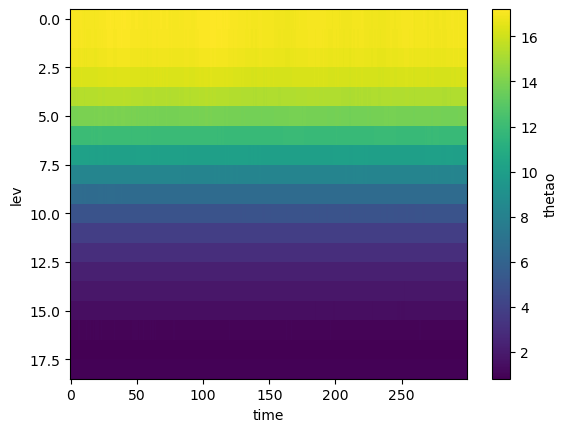

In [43]:
profile_prediction.thetao.plot(x='time', yincrease=False)

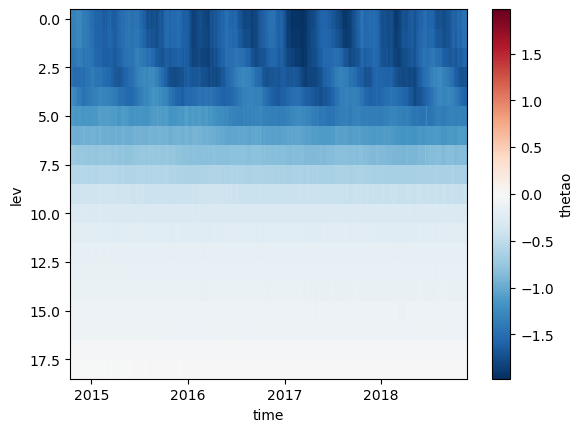

In [44]:
(profile_prediction-profile_groundtruth).thetao.plot(x='time', yincrease=False)

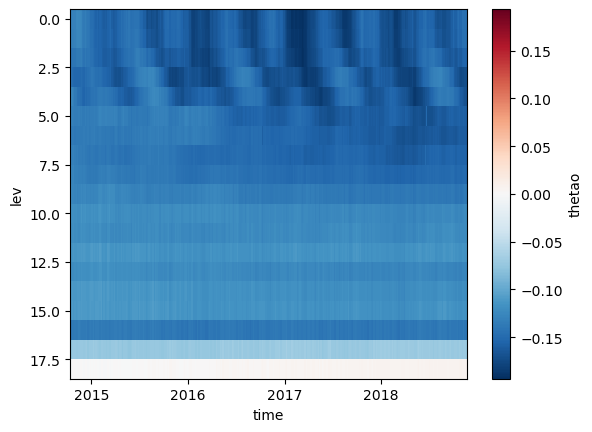

In [45]:
ref_std = profile_stdv_groundtruth.mean('time')
((profile_prediction-profile_groundtruth)/ref_std).thetao.plot(x='time', yincrease=False)

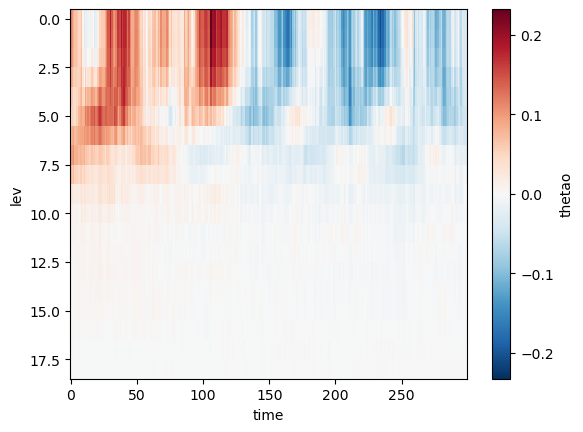

In [47]:
(profile_prediction-profile_prediction.mean('time')).thetao.plot(x='time', yincrease=False)

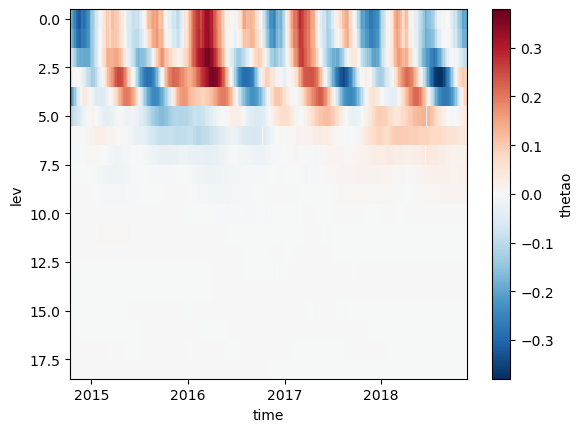

In [46]:
(profile_groundtruth-profile_groundtruth.mean('time')).thetao.plot(x='time', yincrease=False)

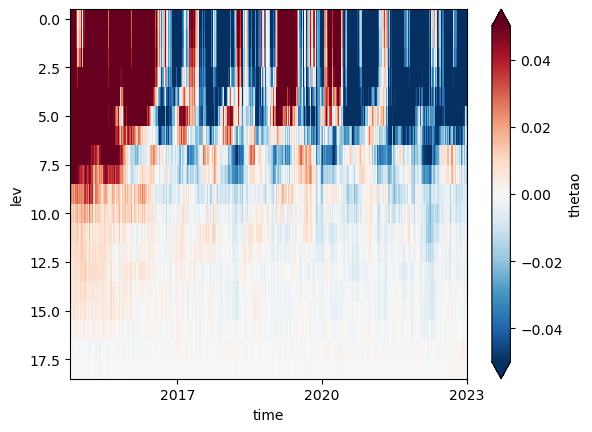

In [21]:
(profile_prediction-profile_prediction.mean('time')).thetao.plot(x='time', yincrease=False, vmax=0.05)

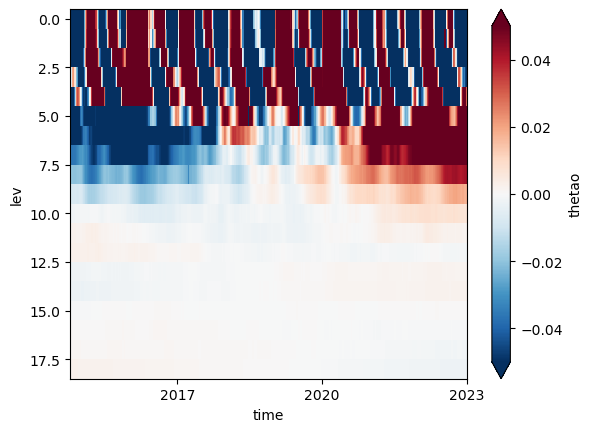

In [20]:
(profile_groundtruth-profile_groundtruth.mean('time')).thetao.plot(x='time', yincrease=False, vmax=0.05)

## Seasonal maps

In [10]:
def seasonal_composite(ds:xr.Dataset) -> xr.Dataset:
    # maybe use flox?
    return ds.groupby('time.season').mean('time')

In [11]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    seasonal_prediction = seasonal_composite(ds_prediction).load()
    seasonal_groundtruth = seasonal_composite(ds_groundtruth).load()

[########################################] | 100% Completed | 179.20 s
[########################################] | 100% Completed | 77.11 s


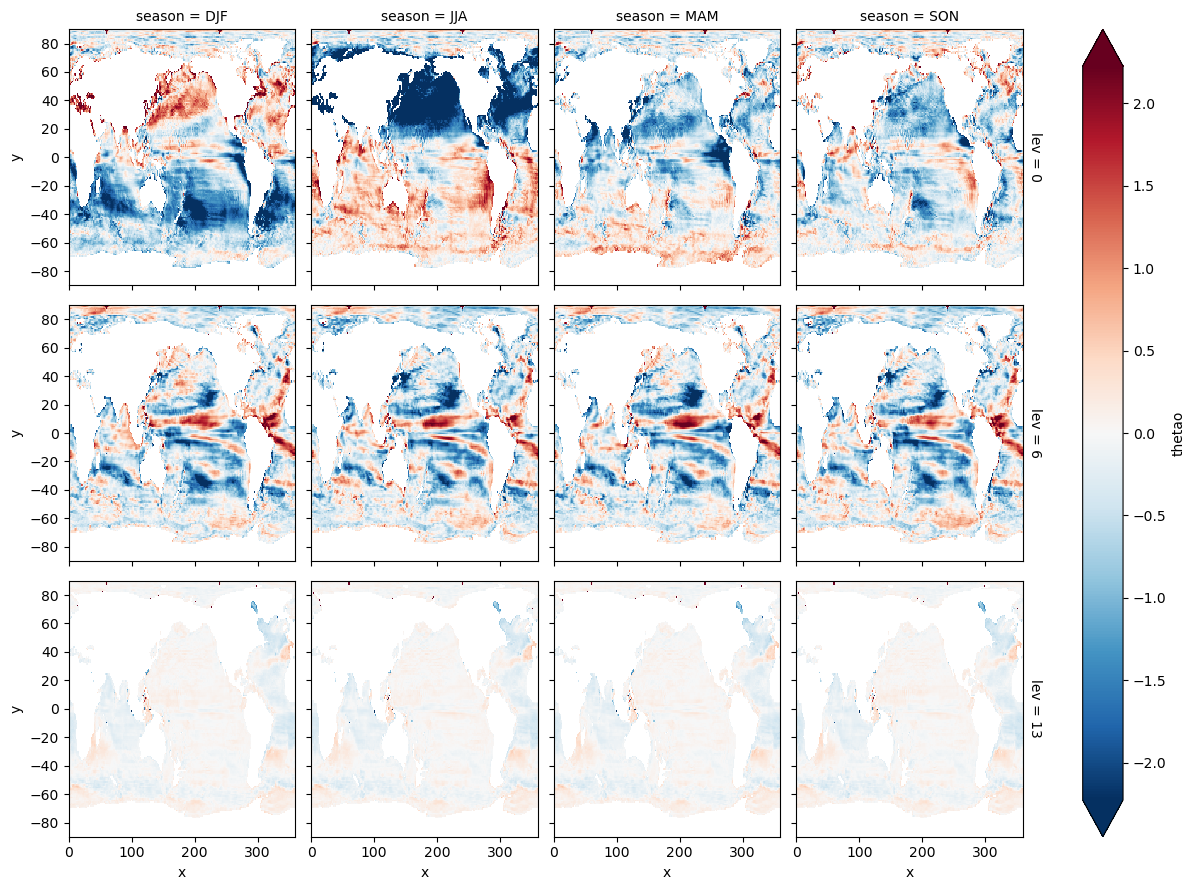

In [22]:
(seasonal_prediction-seasonal_groundtruth).isel(lev=[0, 6, 13]).thetao.plot(col='season', row='lev', robust=True)